# Segmentation of dash camera images

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
import albumentations as A
import time

<pre>
Information of the data can be seen here <a href='http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/'>Dashcam dataset</a>

This dataset was sourced from <a href='https://github.com/alexgkendall/SegNet-Tutorial/tree/master/CamVid'>alexgkendall</a>

The dataset we will be using has images with its corresponding masks.
</pre>

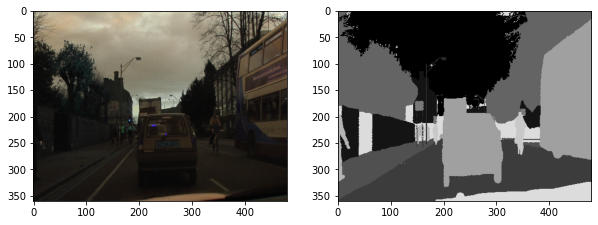

In [12]:
path = 'F:/Dataset/CamVid/'
samp_img = cv2.imread(path+'data/'+os.listdir(path+'data')[80])
samp_mask = cv2.imread(path+'dataannot/'+os.listdir(path+'dataannot')[80])
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(samp_img)
plt.subplot(122)
plt.imshow(samp_mask*20)
plt.show()

There are 12 different classes present in the dataset 
- 0 -> sky
- 1 -> building
- 2 -> street lamp
- 3 -> road
- 4 -> sidewalk
- 5 -> vegetation
- 6 -> traffic sign
- 7 -> railing
- 8 -> vehicle
- 9 -> person
- 10 -> cycle/bike rider
- 11 -> background/non labelled

Lets see how that looks like individually

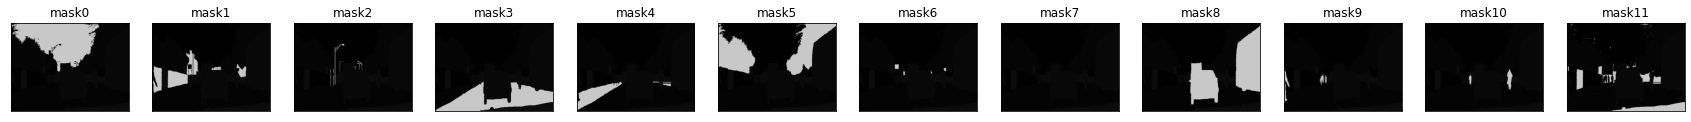

In [3]:
plt.figure(figsize=(30,20))
for i in range(12):
    plt.subplot(1,12,i+1)
    plt.title('mask'+str(i))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.where(samp_mask==i, 200, samp_mask))
plt.show()

Hmmm, the sky is marked as and I don't like that, we gotta make this right by adding 1 to each of the class labels so that we dont miss the sky, trust me, I've missed the sky a lot!

In [4]:
samp_mask = samp_mask+1 
samp_mask = np.where(samp_mask==12, 0, samp_mask)

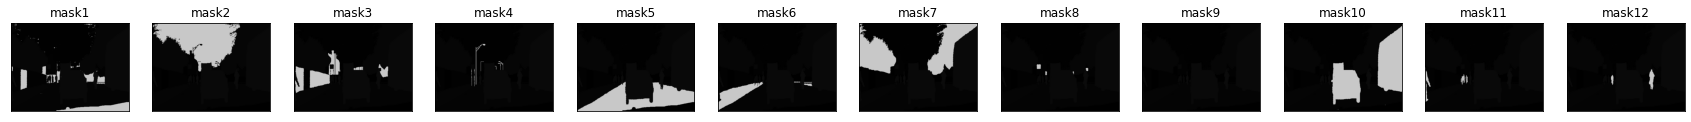

In [5]:
plt.figure(figsize=(30,20))
for i in range(12):
    plt.subplot(1,12,i+1)
    plt.title('mask'+str(i+1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.where(samp_mask==i, 200, samp_mask))
plt.show()

Much better!!

In [8]:
label = []
for i in os.listdir(path+'dataannot'):
    samp_mask = cv2.imread(path+'dataannot/'+i)+1
    samp_mask = np.where(samp_mask==12, 0, samp_mask)
    uq = np.unique(samp_mask)
    for k in range(len(uq)):
        label.append(uq[k])
print('Number of unique class')
print(set(label))

Number of unique class
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


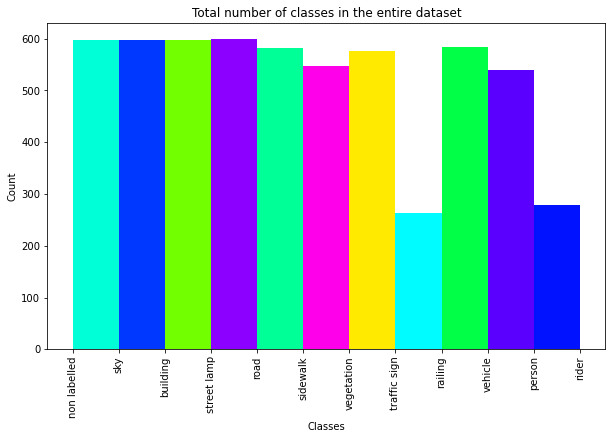

In [10]:
fig,ax = plt.subplots(figsize=(10,6))
_,_,patch = ax.hist(label, bins=np.arange(1,13))
cmap = plt.get_cmap('gist_rainbow_r')
color = [cmap(i) for i in np.random.uniform(0,1,12)]
for i in range(0,11):
    patch[i].set_facecolor(color[i])
plt.xlabel('Classes')
plt.ylabel('Count')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(('non labelled', 'sky','building','street lamp','road','sidewalk',
                   'vegetation','traffic sign','railing','vehicle','person','rider',), rotation=90)
plt.title('Total number of classes in the entire dataset')
plt.show()

Few images have traffic signs and motorcyle riders in them.

In [8]:
label_clr = {'non labelled':0, 'sky':1, 'buildings':2, 'poles/street lamp':3, 'road':4, 'sidewalk':5,
            'vegetation':6, 'traffic sign':7, 'railing':8, 'vehicle':9, 'person':10,
            'rider':11}

Just a dictionary with the class labels...

Creating our dataset

In [9]:
data = [path+'data/'+s for s in os.listdir(path+'data')]
mask = [path+'dataannot/'+s for s in os.listdir(path+'dataannot')]
data_df = pd.DataFrame({'images':data,'mask':mask})
data_df.head()

,images,mask
0,F:/Dataset/CamVid/data/0001TP_006690.png,F:/Dataset/CamVid/dataannot/0001TP_006690.png
1,F:/Dataset/CamVid/data/0001TP_006720.png,F:/Dataset/CamVid/dataannot/0001TP_006720.png
2,F:/Dataset/CamVid/data/0001TP_006750.png,F:/Dataset/CamVid/dataannot/0001TP_006750.png
3,F:/Dataset/CamVid/data/0001TP_006780.png,F:/Dataset/CamVid/dataannot/0001TP_006780.png
4,F:/Dataset/CamVid/data/0001TP_006810.png,F:/Dataset/CamVid/dataannot/0001TP_006810.png


In [2]:
#data_df.to_csv('seg_data.csv', index=False)
data_df = pd.read_csv('seg_data.csv')

Create a dataset and store it for future use

We will be using the albumentations tool to augment our images, it is an extremely fast tool that helps
in deep learning tasks.

Read more about albumentations and their different augmentations <a href='https://albumentations.ai/docs/'>here</a>

<img src='https://albumentations.ai/assets/img/custom/top_image.jpg'>

Source: albumentations.ai

In [14]:
# Visualization for albumentations
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))
        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))
        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

Here we implement albumentation transform

In [3]:
# Sanity check to keep pixels in masks b/w 0-1
def clip_mask(mask, **args):
    return mask.round().clip(0,1)

# Apply albumentations augmentation
# Read more about it here https://albumentations.ai/docs/
def transform_train(res=128, clip=None):
    transform = A.Compose([
        A.Resize(res,res),
        A.OneOf([
            A.RandomRotate90(p=1),
            A.HorizontalFlip(p=1),
            A.VerticalFlip(p=1),
            ], p=1),
        A.OneOf([
            A.Perspective(p=1),
            A.GridDistortion(distort_limit=0.02,p=1),
            A.GaussNoise(var_limit=5,p=1),
        ], p=0.9),
        A.OneOf([
            A.Sharpen(p=1),
            A.Blur(p=1),
            A.MotionBlur(p=1),
        ], p=0.9),
        A.RandomCrop(res, res, p=1),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, border_mode=0, p=0.8),
        A.CLAHE(clip_limit=2, p=0.8),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.8),    
        A.RandomGamma(p=0.8),
        A.Lambda(mask=clip)
    ])
    return transform

def transform_test(res=128, clip=None):
    transform = A.Compose([
        A.Resize(res,res)])
    return transform

(360, 480, 3) (360, 480, 3)
(128, 128, 3) (128, 128, 3)


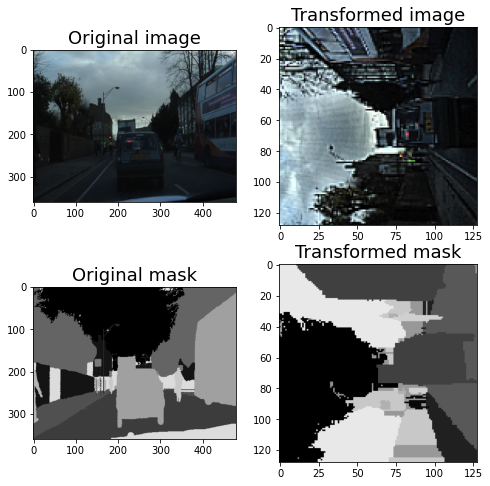

In [15]:
# Sample images transformed
samp_img =  cv2.imread(path+'data/'+os.listdir(path+'data')[80])
samp_img = cv2.cvtColor(samp_img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path+'dataannot/'+os.listdir(path+'dataannot')[80]) + 1
augmented = transform_train()(image=samp_img, mask=samp_mask)

image_heavy = augmented['image']
mask_heavy = augmented['mask']*200
print(samp_img.shape, samp_mask.shape)
print(image_heavy.shape, mask_heavy.shape)
visualize(image_heavy, mask_heavy, original_image=samp_img, original_mask=samp_mask*20)

In [4]:
# Plotting to visualize images from dataset
# Can also be used to visualize individual channels
def visualize_plot(image, mask):
    n = mask.shape[-1]+1
    plt.figure(figsize=(30,15))
    image = (image).astype('int')
    plt.subplot(1, n, 1)
    plt.title('image')
    plt.imshow(image)
    mask = (mask).astype('int')
    for i in range(1,n):
        plt.subplot(1, n, i + 1)
        plt.title('mask'+str(i))
        plt.imshow(mask[:,:,i-1])
    plt.show()
    

Here we define the dataset and create batches

In [5]:
label_clr = {'non labelled':0, 'sky':1, 'buildings':2, 'poles/street lamp':3, 'road':4, 'sidewalk':5,
            'vegetation':6, 'traffic sign':7, 'railing':8, 'vehicle':9, 'person':10, 'rider':11}
  
def normalize(x):
    '''
    Making the image normalized for plotting
    '''
    xmax = np.max(x)
    xmin = np.min(x)
    x = (x-xmin)/(xmax-xmin)
    return x.clip(0,1)

def get_preprocessing(preprocessing):
    '''
    Apply preprocessing used in pretrained network.
    This preprocessing function is received from the segmentation backbone itself.
    '''
    transform = A.Compose([A.Lambda(image=preprocessing)])
    return transform
    
# Data loader class
class Dataset:
    # Declare all the class
    CLASSES = {'non labelled':0, 'sky':1, 'buildings':2, 'poles/street lamp':3, 'road':4, 'sidewalk':5,
            'vegetation':6, 'traffic sign':7, 'railing':8, 'vehicle':9, 'person':10, 'rider':11}
    
    def __init__(self, images, masks, classes=None, augment=None, 
                 image_size = 256, preprocessing=None, clip=None):
        self.images_list = images.values
        self.masks_list = masks.values      
        # Get int class values from str
        self.class_values =list(set(self.CLASSES[cls] for cls in classes))  
        # Declare augmentations and preprocessing
        self.augment = augment(image_size, clip)
        self.preprocess = preprocessing
        self.img_size = image_size
    
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_list[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Replace background with sky
        mask = cv2.imread(self.masks_list[i]) + 1
        mask = np.where(mask==12, 0, mask)
        # Create multichannel mask (extract objects from mask)
        masks = np.zeros((mask.shape[0], mask.shape[1], len(self.class_values)+1))
        for i in range(len(self.class_values)):
            masks[:,:,i+1] = np.where(mask[:,:,0]==self.class_values[i],1,0)
        mask = masks.astype('float')
        background = 1 - mask.sum(axis=-1)
        mask[:,:,0] = background
        augment = self.augment(image=image, mask=mask)
        image = augment['image']
        mask = augment['mask']
        if self.preprocess is not None:
            preprocess = self.preprocess(image=image, mask=mask)
            image, mask = preprocess['image'], preprocess['mask']
        del masks
        return image, mask
    
    # Used for len()    
    def __len__(self):
        return len(self.images_list)
    
    
class Dataloder(tf.keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        tdata = []
        for j in range(start, stop):
            tdata.append(self.dataset[j])
        # transpose list of lists
        batch = []
        for val in zip(*tdata):
            batch.append(np.stack(val, axis=0))
        return tuple(batch)
    
    def __len__(self):
        # returns no. of batches when len() is used
        return len(self.dataset) // self.batch_size
    


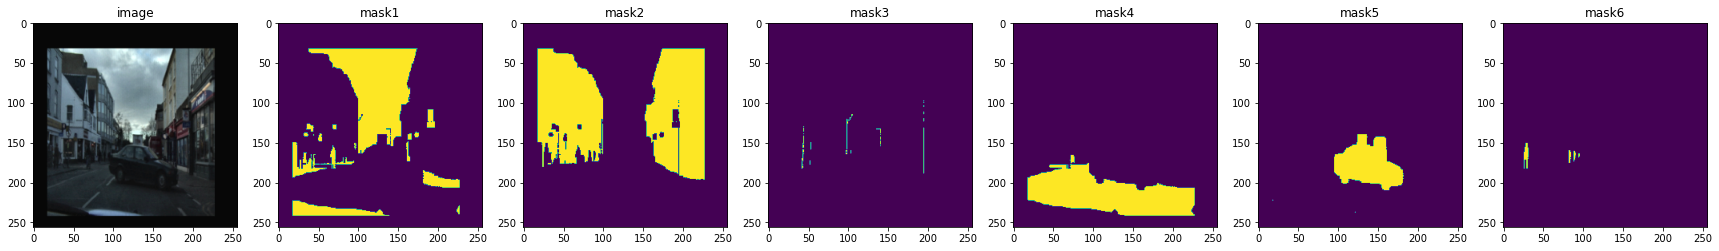

(256, 256, 3) (256, 256, 6)


In [8]:
# Visualize an augemented image and their individual mask
Class = ['vehicle', 'person', 'poles/street lamp', 'buildings', 'road']
dataset = Dataset(data_df['images'], data_df['mask'], classes=Class, 
                  image_size=256, augment=transform_train)

image, mask = dataset[50] 
visualize_plot(image,mask)
print(image.shape, mask.shape)

In [5]:
# Plotting functions

# Plot the IoU score and loss
def plot_metrics(history):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(range(10),history.history['iou_score'], label='iou')
    plt.plot(range(10),history.history['val_iou_score'], label='val_iou')
    plt.title('IoU v/s Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.subplot(122)
    plt.plot(range(10),history.history['loss'], label='loss')
    plt.plot(range(10),history.history['val_loss'], label='val_loss')
    plt.title('Loss v/s Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the predicted image if it has only 3 channels (ex, (256,256,3))
def plot(dataloader, model, Class, N=20):
    images, image_mask, pred_mask = [], [], []
    rng = np.random.randint(75, size=N)
    for i in rng:
        x = dataloader[i]
        images.append(normalize(x[0][0]))
        image_mask.append((x[1][0]))
        pred_mask.append((model.predict(x[0])[0]))
    images = normalize(images)
    for i in range(N):
        plt.figure(figsize=(30,15))
        plt.subplot(131)
        plt.title('Image')
        plt.imshow(images[i])
        plt.subplot(132)
        plt.title('Mask')
        plt.imshow(image_mask[i]) 
        plt.subplot(133)
        plt.title('Predicted Mask')
        plt.imshow(pred_mask[i])
        plt.show()

def plot_bench(image, mask, pred):
    plt.figure(figsize=(30,15))
    plt.subplot(131)
    plt.title('Test Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Test Mask')
    plt.imshow(mask) 
    plt.subplot(133)
    plt.title('Predicted Mask')
    plt.imshow(pred)
    plt.show()

## Training
- For training, we well look at the UNet model with different backbones.
- Backbone means we will the the skeleton of different architectures and add UNet to its tail.
- Each model will use the imagenet weights in their backbone.
- Each model will be trained for 10 epochs with the same class and the same image size.
- The time taken, IoU score and loss will be recorded and compared.
- This will be done on a 2gb GTX 750ti which is not ideal for deep models like this but
  this is just a test for its capability.

In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import segmentation_models as sm
import datetime
# Defaults to keras, switch to tf.keras if needed
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [10]:
# Train test split 
x_train, x_test, y_train, y_test = train_test_split(data_df['images'], data_df['mask'],
                                                   test_size=0.25, random_state = 69)

In [11]:
# Declare optimizers and classes
# For all benchmarks, we will use only 2 classes.
# For visualizing more than 2 classes, we can either visualize the channels individually (recommended)
# or use argmax to get a 1 channel matrix with the highest value which might give poor visualizations if
# your IoU score is low.
optim = tf.keras.optimizers.Adam(0.0001)
dice_loss = sm.losses.cce_dice_loss
enc_weights = 'imagenet'
Class = ['person','vehicle']
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


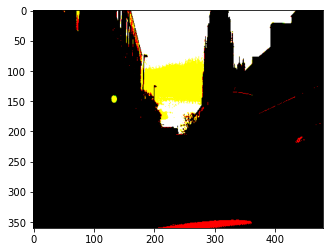

In [16]:
img = cv2.imread(data_df['images'].values[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(data_df['mask'].values[0])
transform = A.Compose([A.Lambda(image = preprocess_input)])
tr = transform(image=img, mask=mask)
plt.imshow(tr['image'])

## Lets talk about the metrics we will use.
### Dice Loss

$
    Dice Coefficient = \frac{2|A\cap B|}{|A|+|B|}
$

* Where $|A\cap B|$ represents the common elements between set A and set B and this is divided by the sum of all the elements in set A and set B.
* We can also approximate $|A\cap B|$ as the element wise multiplication between the ground truth and the predicted segmentation.
* Dice coefficient ranges between 0 to 1 where 0 means the predicted segmentation has no similarity with the ground truth and 1 means it perfectly matches with the ground truth.
* To use Dice coefficient as a loss function which can be minimized, we simply do 1 - Dice Coefficient.
$
    Dice Loss = 1 - \frac{2|A\cap B|}{|A|+|B|}
$
* In segmentation model, the formula uses the values from the confusion matrix to formulate the loss.
$ 
    Dice Loss = 1 - (1 + \beta^2)\frac{precision * recall}{\beta^2 * precision * recall}
$
* Where $\beta$ is the smoothing parameters to prevent division by 0.
* A mathematical example shown below,
​
$$
\
\begin{bmatrix}
    0.01  &  0.03  &  0.04     \\
    0.82  &  0.92  &  0.87     \\
    0.91  &  0.95  &  0.79     \\
\end{bmatrix}
*
\begin{bmatrix}
    0  &  0  &  0     \\
    1  &  1  &  1     \\
    1  &  1  &  1
\end{bmatrix} 
= 
\begin{bmatrix}
    0.0  &  0.0  &  0.0     \\
    0.82  &  0.92  &  0.87     \\
    0.91  &  0.95  &  0.79     \\
\end{bmatrix}
= 5.26
\
\\
|A| = 5.34 \quad  |B| = 6
\\
\frac{2 * 5.26}{5.34 + 6} = 0.927
\\
Loss = 1 - 0.927 = 0.07
$$

### IoU Score
- IoU score, also called Intersection over Union or Jaccard Index is used to compare the overlap between the segmentations of the predictions and the ground truth. The higher the score, the better the overlap. A score of 1 means that the predictions perfectly overlaps the ground truth and a score of 0 means that there is no overlap.
- The IoU score is calculated by,

    $
        IoU(A,B) = \frac{A\cap B}{A\cup B}
    $

### U-Net
- U-Net was developed for biomedical image segmentation where the goal was to label every pixel (if possible) using as less data as possible. This works by zooming into images using convolutional layers and downsampling the images to get features, and the upsampling the features to the size of the original image where each feature gets its own channel. 
- Suppose we input an RGB image of size 256x256 pixels with 3 channels into the network and want to predict 5 classes, the output of the network will be an matrix of size 256x256 with 5 channels.
- Ie, shape (256, 256, 3) = shape (256, 256, 5) 
- The paper for U-Net can be found <a href='https://arxiv.org/abs/1505.04597'>here</a>

### VGG-19 backbone

VGG-19 is implemented from the paper <a href='https://arxiv.org/abs/1409.1556'>Very Deep Convolutional Network for Large Scale Images</a> where they use deep Conv(3x3) layers to get state of the art results. Here we use the 19 layer deep VGG-19 model.

In [12]:
BACKBONE = 'vgg19'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [11]:
#create model
model_unet_vgg = sm.Unet(BACKBONE, classes=len(Class)+1, activation='softmax',
                         encoder_weights=enc_weights, decoder_block_type='upsampling')

In [12]:
model_unet_vgg.compile(optim, dice_loss, metrics)
model_unet_vgg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [13]:
x_train_data = Dataset(x_train, y_train, preprocessing = get_preprocessing(preprocess_input),
                       augment=transform_train, classes=Class, image_size=128)
x_test_data = Dataset(x_test, y_test, preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)

train_dataloader = Dataloder(x_train_data, batch_size=2)
valid_dataloader = Dataloder(x_test_data, batch_size=2)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(2, 128, 128, 3)
(2, 128, 128, 3)


In [14]:
start = time.time()
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.00001,patience=2)]
with tf.device('gpu'):
    history_vgg = model_unet_vgg.fit(train_dataloader , steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=valid_dataloader,callbacks=callbacks)
print('Elapsed Time: {}s'.format(round(time.time()-start,2)))

Epoch 1/10
225/225 [==============================] - 68s 254ms/step - loss: 0.8959 - iou_score: 0.2448 - f1-score: 0.2921 - val_loss: 0.8363 - val_iou_score: 0.2955 - val_f1-score: 0.3562
Epoch 2/10
225/225 [==============================] - 56s 250ms/step - loss: 0.7293 - iou_score: 0.3317 - f1-score: 0.3817 - val_loss: 0.7006 - val_iou_score: 0.3390 - val_f1-score: 0.3682
Epoch 3/10
225/225 [==============================] - 56s 250ms/step - loss: 0.6706 - iou_score: 0.3611 - f1-score: 0.4233 - val_loss: 0.7194 - val_iou_score: 0.3258 - val_f1-score: 0.3458
Epoch 4/10
225/225 [==============================] - 56s 250ms/step - loss: 0.6326 - iou_score: 0.3879 - f1-score: 0.4545 - val_loss: 0.5893 - val_iou_score: 0.4266 - val_f1-score: 0.4791
Epoch 5/10
225/225 [==============================] - 56s 250ms/step - loss: 0.6218 - iou_score: 0.3960 - f1-score: 0.4623 - val_loss: 0.5627 - val_iou_score: 0.4562 - val_f1-score: 0.5093
Epoch 6/10
225/225 [==============================] - 5

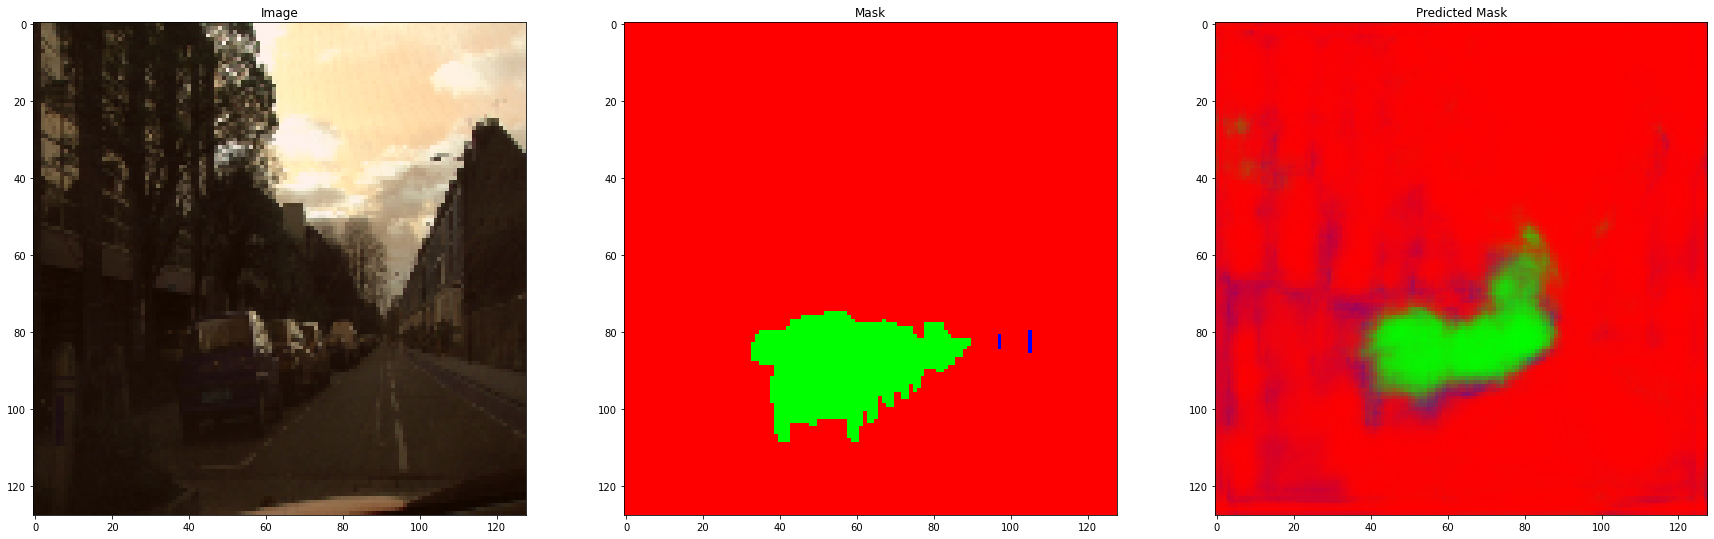

In [15]:
plot(Dataloder(x_test_data, batch_size=1), model=model_unet_vgg, N=1, Class=Class)

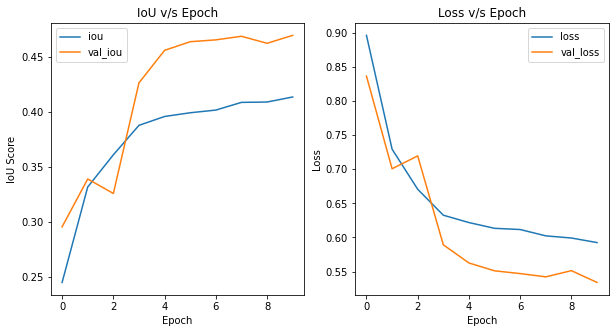

In [18]:
plot_metrics(history_vgg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


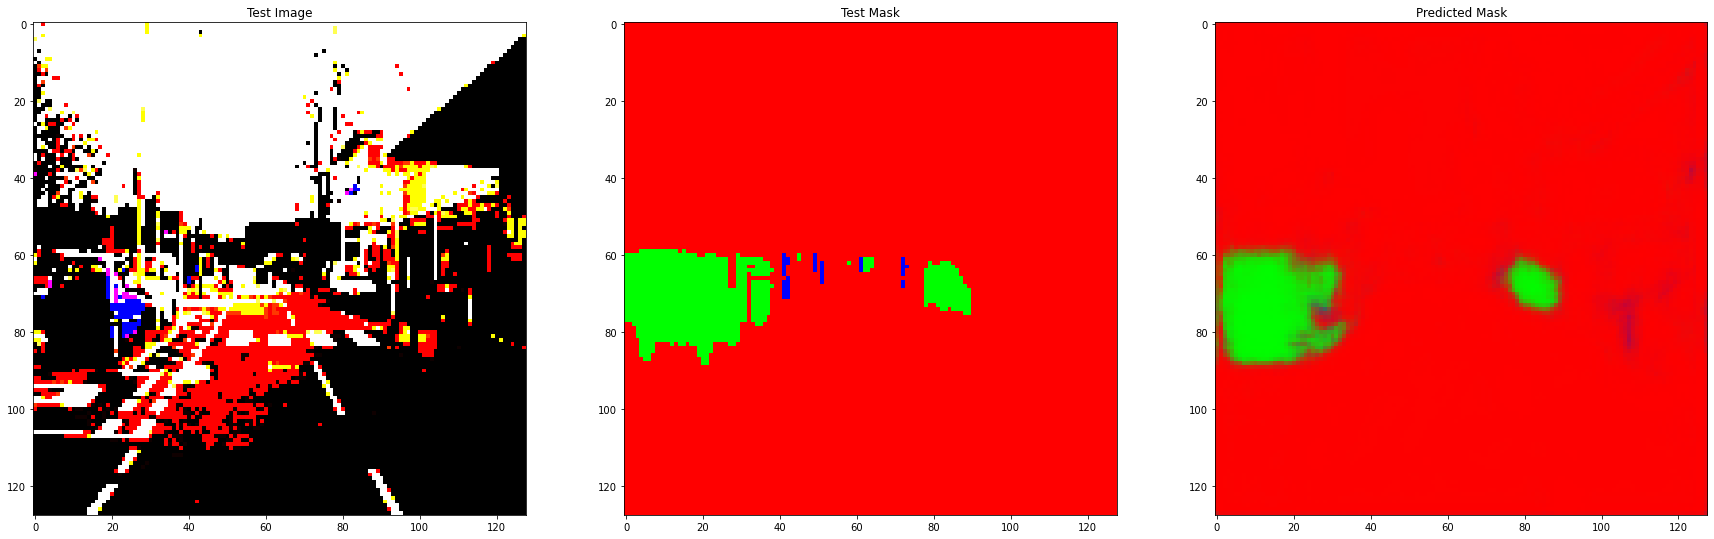

In [17]:
# Control image

control_data = Dataset(data_df['images'], data_df['mask'], preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)
image, label = control_data[200]
t = A.Compose([A.Resize(128,128)])(image=image, mask=label)
image, label = t['image'], t['mask']
pred = model_unet_vgg.predict(np.expand_dims(image,0))
plot_bench(image, label, pred[0])

### ResNet-50 backbone
<a href='https://arxiv.org/abs/1512.03385'>Residual Networks</a> use deep neural networks in training while still maintaining low complexity. This is achieved by using skip connections or by using residual layers as mentioned in the paper. A 152 layer ResNet is 8 times the size of VGG but still has lower complexity. Here we use ResNet-50 which is 50 layers deep. 

In [9]:
BACKBONE = 'resnet50'
enc_weights = 'imagenet'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_unet_res = sm.Unet(BACKBONE, classes=3, activation='softmax',encoder_weights=enc_weights,
               decoder_block_type='upsampling')

model_unet_res.compile(optim, dice_loss, metrics)
model_unet_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [10]:
x_train_data = Dataset(x_train, y_train, preprocessing = get_preprocessing(preprocess_input),
                       augment=transform_train, classes=Class, image_size=128)
x_test_data = Dataset(x_test, y_test, preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)

train_dataloader = Dataloder(x_train_data, batch_size=1)
valid_dataloader = Dataloder(x_test_data, batch_size=1)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(1, 128, 128, 3)
(1, 128, 128, 3)


In [11]:
start = time.time()
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)]
with tf.device('gpu'):
    history_res = model_unet_res.fit(train_dataloader , steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=valid_dataloader,callbacks=callbacks)
print('Elapsed Time: {}s'.format(round(time.time()-start,2)))

Epoch 1/10
450/450 [==============================] - 87s 172ms/step - loss: 0.7663 - iou_score: 0.3319 - f1-score: 0.3847 - val_loss: 0.6670 - val_iou_score: 0.4335 - val_f1-score: 0.4764
Epoch 2/10
450/450 [==============================] - 78s 174ms/step - loss: 0.6568 - iou_score: 0.3989 - f1-score: 0.4597 - val_loss: 0.6062 - val_iou_score: 0.4591 - val_f1-score: 0.5043
Epoch 3/10
450/450 [==============================] - 78s 173ms/step - loss: 0.6231 - iou_score: 0.4212 - f1-score: 0.4809 - val_loss: 0.5788 - val_iou_score: 0.4773 - val_f1-score: 0.5251
Epoch 4/10
450/450 [==============================] - 76s 169ms/step - loss: 0.5859 - iou_score: 0.4440 - f1-score: 0.5043 - val_loss: 0.5680 - val_iou_score: 0.4571 - val_f1-score: 0.5046
Epoch 5/10
450/450 [==============================] - 77s 171ms/step - loss: 0.5762 - iou_score: 0.4362 - f1-score: 0.4992 - val_loss: 0.5611 - val_iou_score: 0.4645 - val_f1-score: 0.5170
Epoch 6/10
450/450 [==============================] - 7

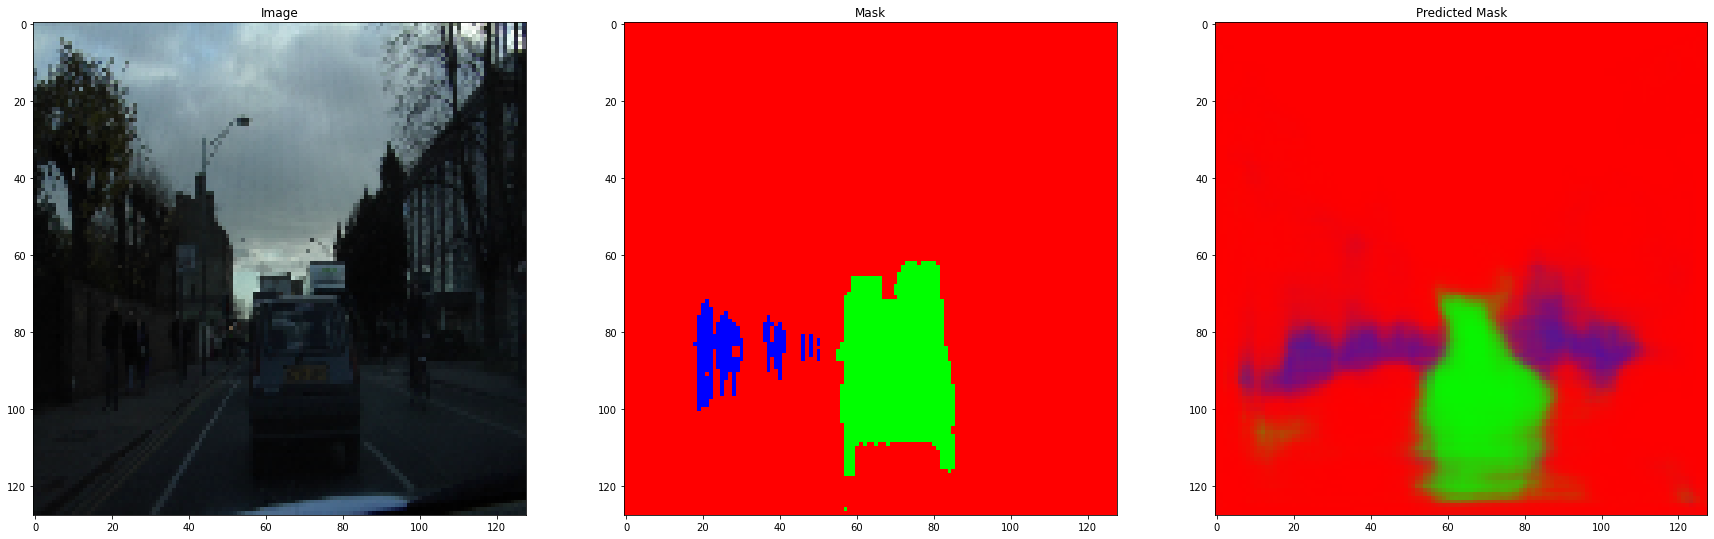

In [12]:
plot(Dataloder(x_test_data, batch_size=1), model=model_unet_res, N=1, Class=Class)

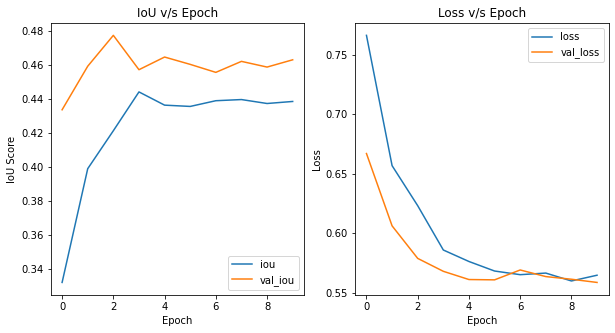

In [13]:
plot_metrics(history_res)

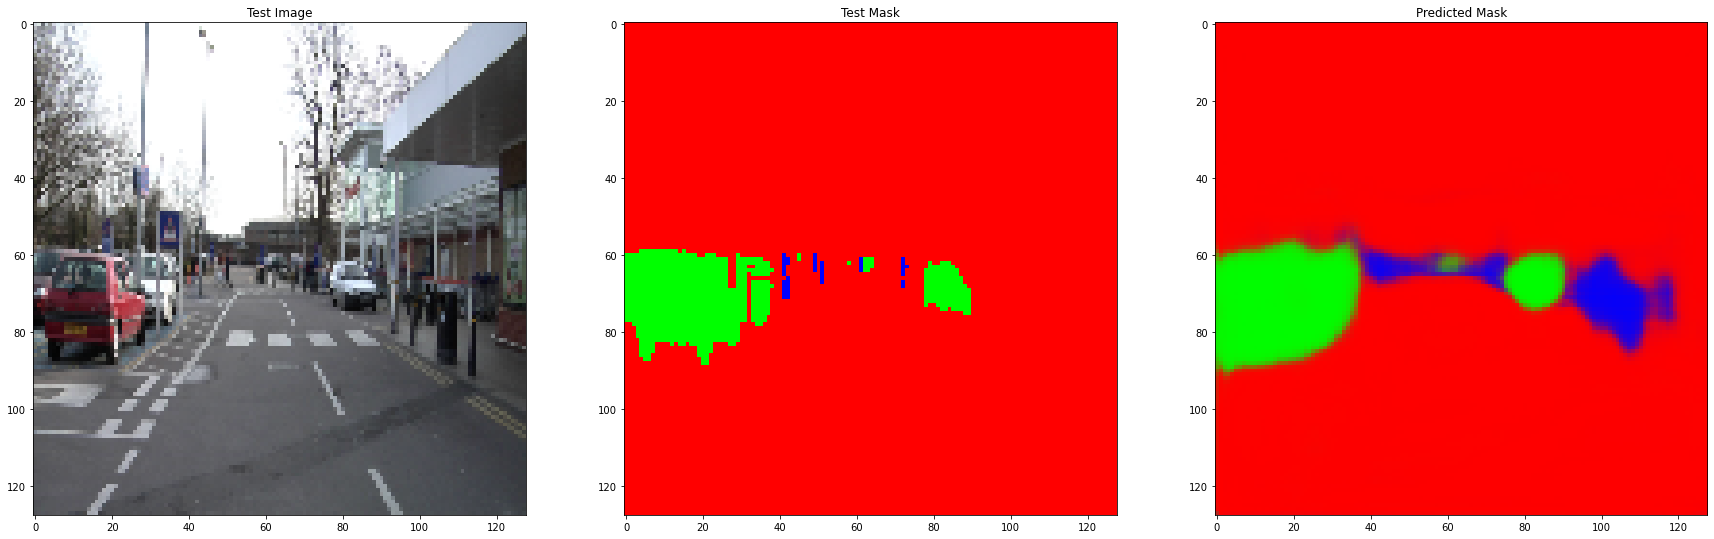

In [26]:
# Control image
control_data = Dataset(data_df['images'], data_df['mask'], preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)
image, label = control_data[200]
transform = A.Compose([A.Resize(128,128)])(image=image, mask=label)
image, label = transform['image'], transform['mask']
pred = model_unet_res.predict(np.expand_dims(image, 0))
plot_bench(image, label, pred[0])

### Inception Backbone

This is model based on the paper <a href='https://arxiv.org/pdf/1409.4842.pdf'>Going deeper with convolutions</a> where they focused on crafting an optimized architecture instead of a deep network. Here we use Inception V3 which is the third version of the Inception net.

In [9]:
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_unet_incv3 = sm.Unet(BACKBONE, classes=3, activation='softmax',encoder_weights=enc_weights,
               decoder_block_type='upsampling')

model_unet_incv3.compile(optim, dice_loss, metrics)
model_unet_incv3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
x_train_data = Dataset(x_train, y_train, preprocessing = get_preprocessing(preprocess_input),
                       augment=transform_train, classes=Class, image_size=128, clip=clip_mask)
x_test_data = Dataset(x_test, y_test, preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)

train_dataloader = Dataloder(x_train_data, batch_size=1)
valid_dataloader = Dataloder(x_test_data, batch_size=1)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(1, 128, 128, 3)
(1, 128, 128, 3)


In [11]:
start = time.time()
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)]
with tf.device('gpu'):
    history_incv3 = model_unet_incv3.fit(train_dataloader , steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=valid_dataloader,callbacks=callbacks)
print('Elapsed Time: {}s'.format(round(time.time()-start,2)))

Epoch 1/10
450/450 [==============================] - 94s 181ms/step - loss: 0.8018 - iou_score: 0.3123 - f1-score: 0.3730 - val_loss: 0.7884 - val_iou_score: 0.3619 - val_f1-score: 0.4231
Epoch 2/10
450/450 [==============================] - 79s 176ms/step - loss: 0.6403 - iou_score: 0.4098 - f1-score: 0.4691 - val_loss: 0.5789 - val_iou_score: 0.4869 - val_f1-score: 0.5317
Epoch 3/10
450/450 [==============================] - 80s 179ms/step - loss: 0.5925 - iou_score: 0.4273 - f1-score: 0.4936 - val_loss: 0.5495 - val_iou_score: 0.4852 - val_f1-score: 0.5331
Epoch 4/10
450/450 [==============================] - 81s 179ms/step - loss: 0.5554 - iou_score: 0.4492 - f1-score: 0.5258 - val_loss: 0.5396 - val_iou_score: 0.4832 - val_f1-score: 0.5441
Epoch 5/10
450/450 [==============================] - 84s 186ms/step - loss: 0.5464 - iou_score: 0.4572 - f1-score: 0.5379 - val_loss: 0.5420 - val_iou_score: 0.4802 - val_f1-score: 0.5412
Epoch 6/10
450/450 [==============================] - 8

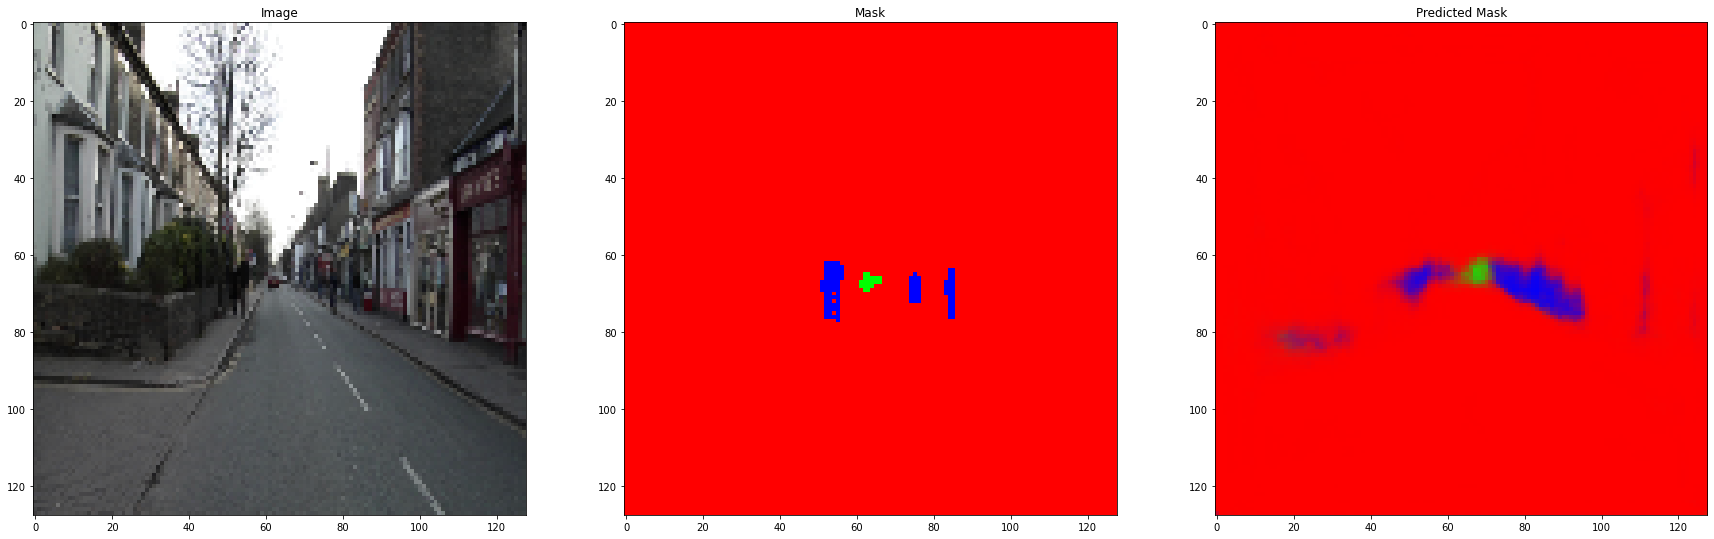

In [12]:
plot(Dataloder(x_test_data, batch_size=1), model=model_unet_incv3, N=1, Class=Class)

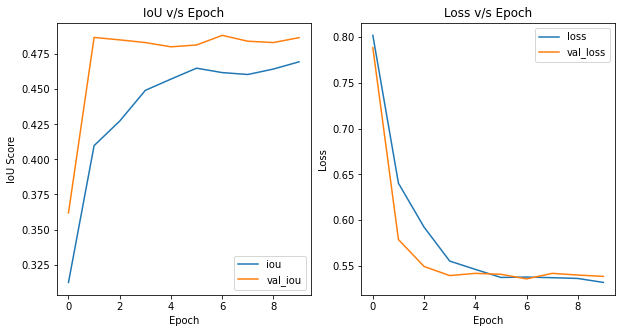

In [14]:
plot_metrics(history_incv3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


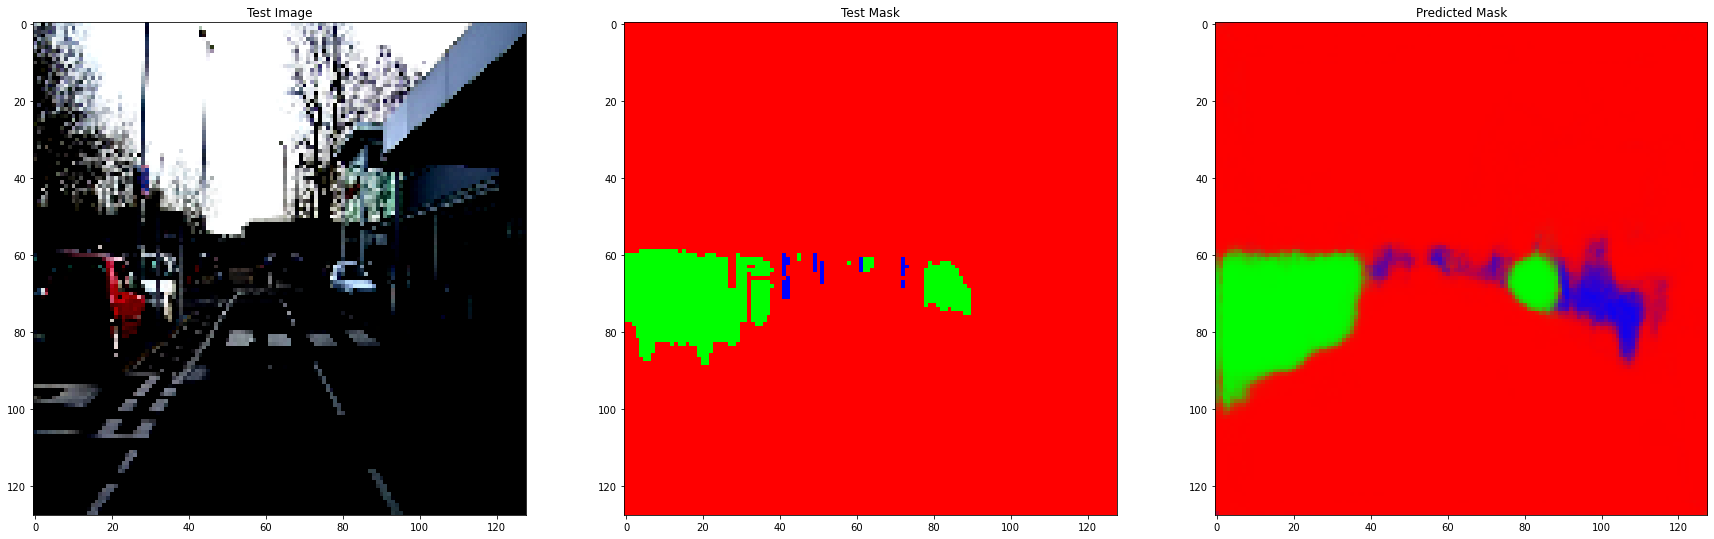

In [13]:
# Control image
control_data = Dataset(data_df['images'], data_df['mask'], preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)
image, label = control_data[200]
transform = A.Compose([A.Resize(128,128)])(image=image, mask=label)
image, label = transform['image'], transform['mask']
pred = model_unet_incv3.predict(np.expand_dims(image,0))
plot_bench(image, label, pred[0])

### DenseNet backbone

DenseNet or <a href='https://arxiv.org/abs/1608.06993'>Densely Connected Convolutional Network</a> was formed on the concept that models can be deeper and efficient if they have layers closer to the input and output. We use DenseNet-121 here as a backbone. 

In [9]:
BACKBONE = 'densenet121'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_unet_d121 = sm.Unet(BACKBONE, classes=3, activation='softmax',encoder_weights=enc_weights,
               decoder_block_type='upsampling')

model_unet_d121.compile(optim, dice_loss, metrics)
model_unet_d121.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [10]:
x_train_data = Dataset(x_train, y_train, preprocessing = get_preprocessing(preprocess_input),
                       augment=transform_train, classes=Class, image_size=128)
x_test_data = Dataset(x_test, y_test, preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)

train_dataloader = Dataloder(x_train_data, batch_size=1)
valid_dataloader = Dataloder(x_test_data, batch_size=1)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(1, 128, 128, 3)
(1, 128, 128, 3)


In [11]:
start = time.time()
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)]
with tf.device('gpu'):
    history_d121 = model_unet_d121.fit(train_dataloader , steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=valid_dataloader,callbacks=callbacks)
print('Elapsed Time: {}s'.format(round(time.time() - start, 2)))

Epoch 1/10
450/450 [==============================] - 97s 177ms/step - loss: 0.8128 - iou_score: 0.3213 - f1-score: 0.3793 - val_loss: 0.7298 - val_iou_score: 0.4102 - val_f1-score: 0.4634
Epoch 2/10
450/450 [==============================] - 75s 167ms/step - loss: 0.6468 - iou_score: 0.4122 - f1-score: 0.4726 - val_loss: 0.6091 - val_iou_score: 0.4605 - val_f1-score: 0.4996
Epoch 3/10
450/450 [==============================] - 70s 156ms/step - loss: 0.6138 - iou_score: 0.4303 - f1-score: 0.4896 - val_loss: 0.5659 - val_iou_score: 0.4885 - val_f1-score: 0.5309
Epoch 4/10
450/450 [==============================] - 71s 157ms/step - loss: 0.5857 - iou_score: 0.4482 - f1-score: 0.5086 - val_loss: 0.5529 - val_iou_score: 0.4980 - val_f1-score: 0.5399
Epoch 5/10
450/450 [==============================] - 70s 156ms/step - loss: 0.5752 - iou_score: 0.4565 - f1-score: 0.5185 - val_loss: 0.5462 - val_iou_score: 0.4977 - val_f1-score: 0.5401
Epoch 6/10
450/450 [==============================] - 7

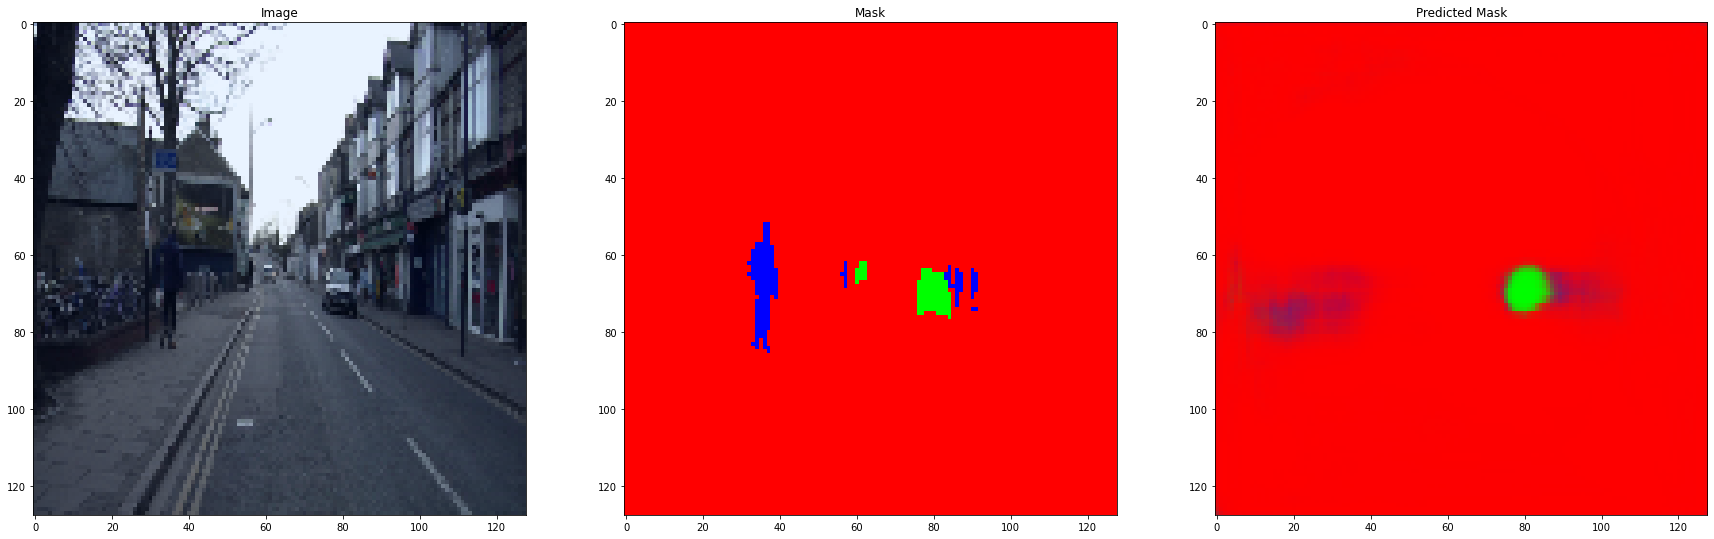

In [13]:
plot(Dataloder(x_test_data, batch_size=1), model=model_unet_d121, N=1, Class=Class)

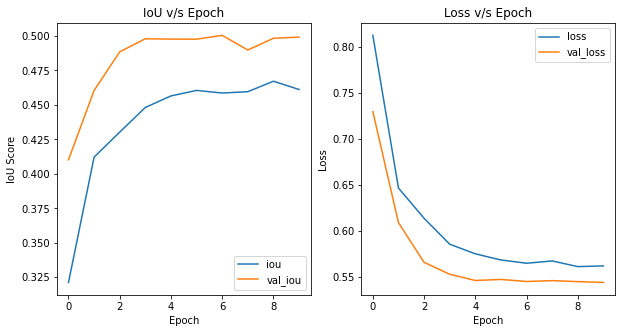

In [14]:
plot_metrics(history_d121)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


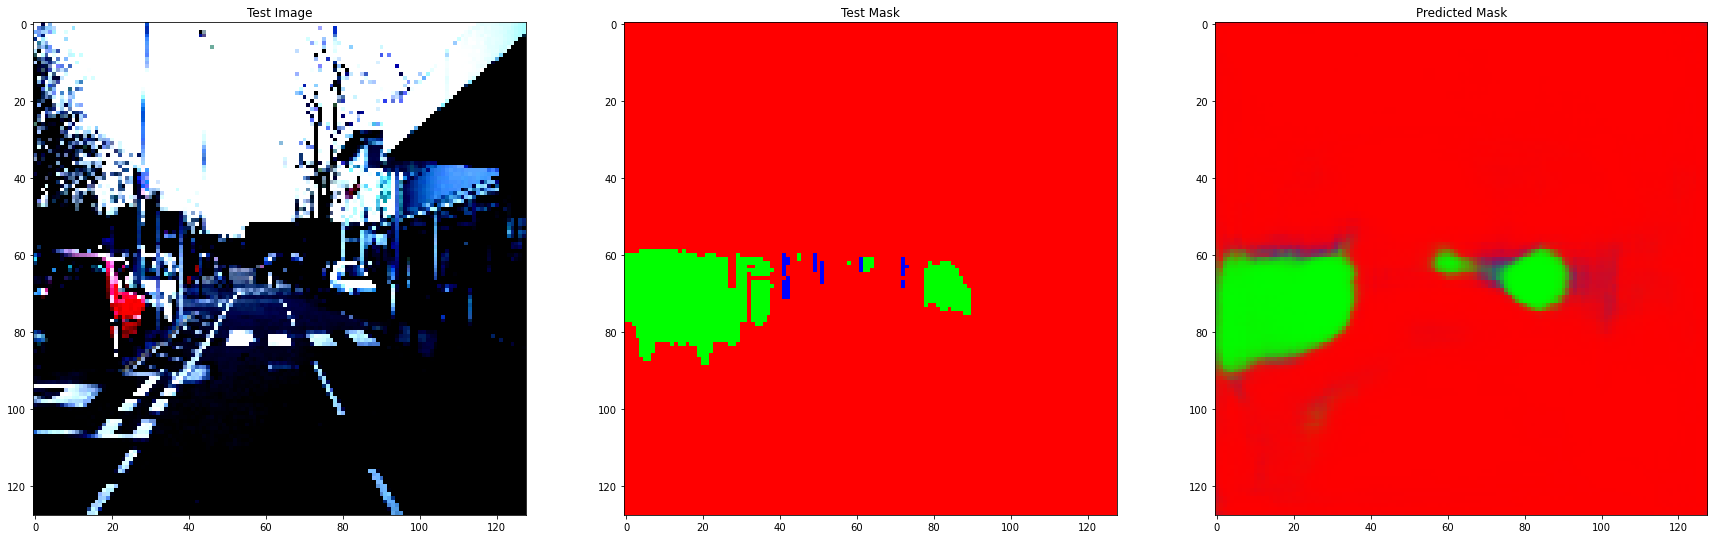

In [15]:
# Control image
control_data = Dataset(data_df['images'], data_df['mask'], preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)
image, label = control_data[200]
transform = A.Compose([A.Resize(128,128)])(image=image, mask=label)
image, label = transform['image'], transform['mask']
pred = model_unet_d121.predict(np.expand_dims(image,0))
plot_bench(image, label, pred[0])

### EfficientNet

Their paper <a href='https://arxiv.org/pdf/1905.11946.pdf'>Rethinking Model Scaling for Convolutional Neural Networks</a> talks about how they use a scaling method called compound coefficient to scale up the images to get a better accuracy. Here we use EfficientNetb7 which is the scaled up version of the baseline EfficientNet.

In [9]:
BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_unet_efnb7 = sm.Unet(BACKBONE, classes=3, activation='softmax',encoder_weights=enc_weights,
               decoder_block_type='upsampling')

model_unet_efnb7.compile(optim, dice_loss, metrics)
model_unet_efnb7.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 6 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 6 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 6 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [10]:
x_train_data = Dataset(x_train, y_train, preprocessing = get_preprocessing(preprocess_input),
                       augment=transform_train, classes=Class, image_size=128, clip=clip_mask)
x_test_data = Dataset(x_test, y_test, preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)

train_dataloader = Dataloder(x_train_data, batch_size=1)
valid_dataloader = Dataloder(x_test_data, batch_size=1)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(1, 128, 128, 3)
(1, 128, 128, 3)


In [11]:
start = time.time()
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)]
with tf.device('gpu'):
    history_efnb7 = model_unet_efnb7.fit(train_dataloader , steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=valid_dataloader,callbacks=callbacks)
print('Elapsed Time: {}s'.format(round(time.time() - start, 2)))

Epoch 1/10
450/450 [==============================] - 257s 503ms/step - loss: 0.8250 - iou_score: 0.3179 - f1-score: 0.3723 - val_loss: 0.6802 - val_iou_score: 0.4471 - val_f1-score: 0.4996
Epoch 2/10
450/450 [==============================] - 226s 503ms/step - loss: 0.6403 - iou_score: 0.4207 - f1-score: 0.4782 - val_loss: 0.5787 - val_iou_score: 0.4727 - val_f1-score: 0.5215
Epoch 3/10
450/450 [==============================] - 227s 505ms/step - loss: 0.5804 - iou_score: 0.4292 - f1-score: 0.5039 - val_loss: 0.5323 - val_iou_score: 0.4765 - val_f1-score: 0.5439
Epoch 4/10
450/450 [==============================] - 230s 511ms/step - loss: 0.5298 - iou_score: 0.4672 - f1-score: 0.5491 - val_loss: 0.5006 - val_iou_score: 0.5036 - val_f1-score: 0.5705
Epoch 5/10
450/450 [==============================] - 230s 512ms/step - loss: 0.5194 - iou_score: 0.4754 - f1-score: 0.5582 - val_loss: 0.4921 - val_iou_score: 0.5119 - val_f1-score: 0.5776
Epoch 6/10
450/450 [==============================

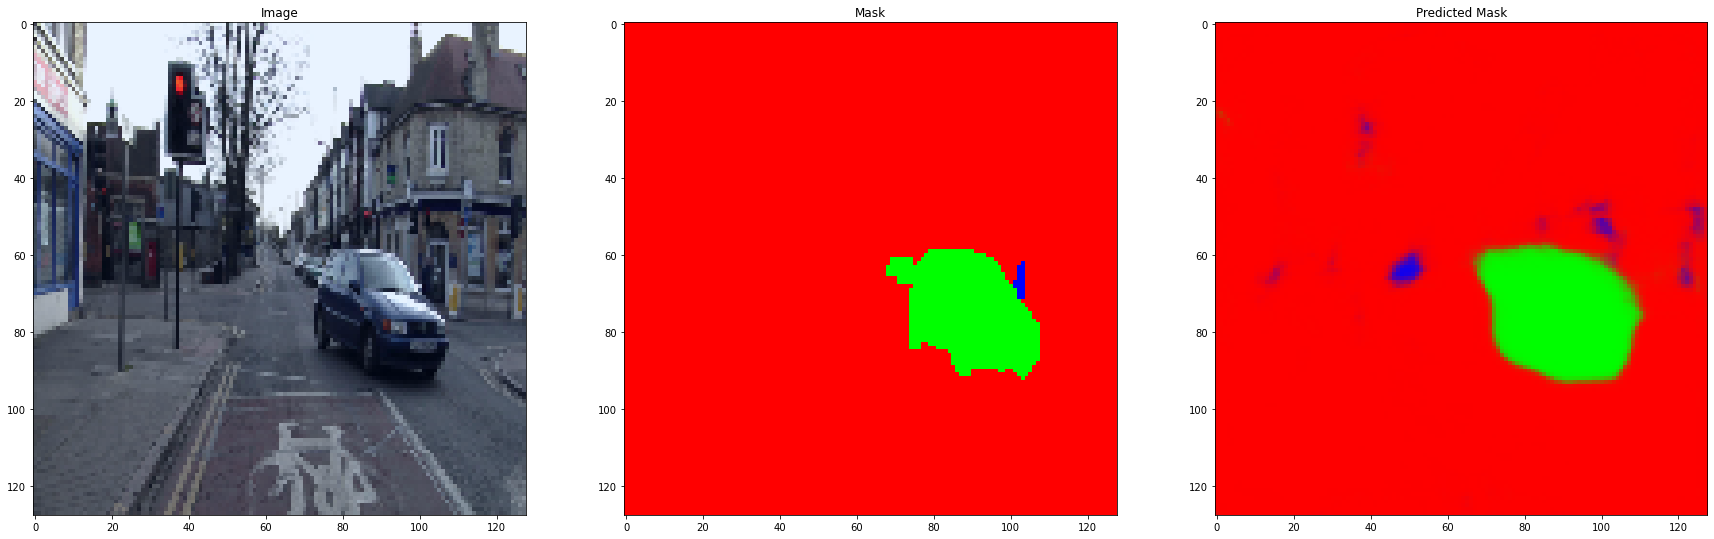

In [13]:
plot(Dataloder(x_test_data, batch_size=1), model=model_unet_efnb7, N=1, Class=Class)

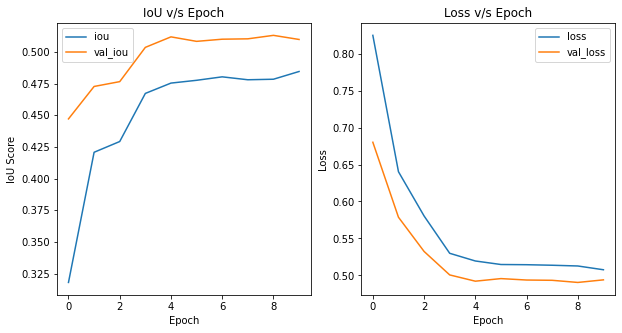

In [14]:
plot_metrics(history_efnb7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


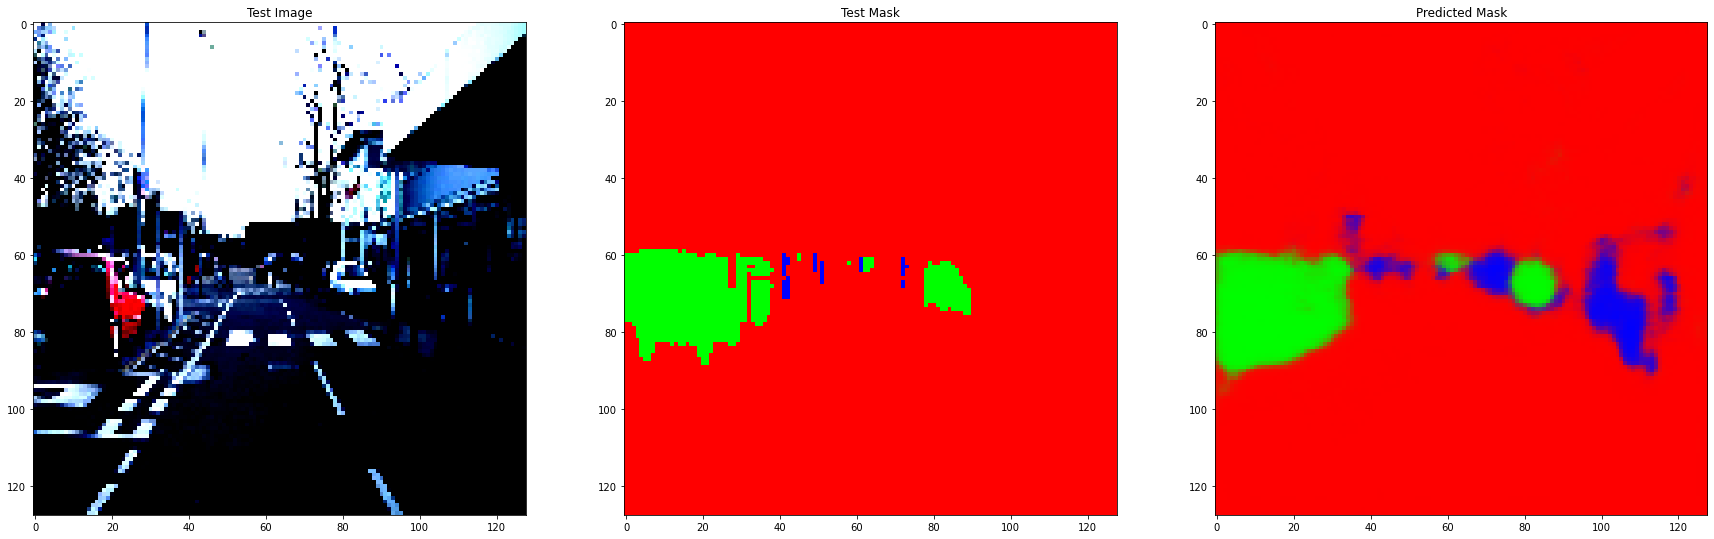

In [15]:
# Control image
control_data = Dataset(data_df['images'], data_df['mask'], preprocessing = get_preprocessing(preprocess_input),
                      augment=transform_test, classes=Class, image_size=128)
image, label = control_data[200]
transform = A.Compose([A.Resize(128,128)])(image=image, mask=label)
image, label = transform['image'], transform['mask']
pred = model_unet_efnb7.predict(np.expand_dims(image,0))
plot_bench(image, label, pred[0])

In [16]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Backbone', 'IoU Score', 'Val IoU Score', 'Loss', 'Val Loss', 'Elapsed Time in seconds']
x.add_row(['VGG-19', '0.4137', '0.4699', '0.5812', '0.5342', '574.76s'])
x.add_row(['ResNet-50', '0.4383', '0.4629', '0.5639', '0.5586', '787.91s'])
x.add_row(['InceptionV3', '0.4695', '0.4868', '0.5321', '0.5387', '901.06s'])
x.add_row(['DenseNet-121', '0.4612', '0.4992', '0.5620', '0.5440', '736.2s'])
x.add_row(['EfficientNetb7', '0.4845', '0.5098', '0.5076', '0.4939', '2301.07s'])
print(x)

+----------------+-----------+---------------+--------+----------+-------------------------+
|    Backbone    | IoU Score | Val IoU Score |  Loss  | Val Loss | Elapsed Time in seconds |
+----------------+-----------+---------------+--------+----------+-------------------------+
|     VGG-19     |   0.4137  |     0.4699    | 0.5812 |  0.5342  |         574.76s         |
|   ResNet-50    |   0.4383  |     0.4629    | 0.5639 |  0.5586  |         787.91s         |
|  InceptionV3   |   0.4695  |     0.4868    | 0.5321 |  0.5387  |         901.06s         |
|  DenseNet-121  |   0.4612  |     0.4992    | 0.5620 |  0.5440  |          736.2s         |
| EfficientNetb7 |   0.4845  |     0.5098    | 0.5076 |  0.4939  |         2301.07s        |
+----------------+-----------+---------------+--------+----------+-------------------------+
